# Homework 2 from Martin Gräf, Richard Baumann and Thomas Block

## Exercise 1

After taking a look at the one-dimensional ising model in Homework 1, we now take a look at the two-dimensional variant. Again we have the hamiltonian:


\begin{equation}
    H(\sigma) = - J \sum_{\langle x~y\rangle} \sigma_x \sigma_y - h \sum_x \sigma_x
\end{equation}





In [1]:
#just importing stuff, nothing to see here yet :)

import numpy as np 
import random as rd
import matplotlib.pyplot as plt
import math
import itertools 
import scipy.special as sp

This time we not only look at the particles left and right of the observed particle, but at the particles above and below. Therefore the hamiltonian looks like this:

\begin{equation}
    H(\sigma) = - J (\sigma_{x-1, y} \sigma_{x, y} + \sigma_{x+1, y} \sigma_{x1, y} + \sigma_{x, y-1} \sigma_{x, y} + \sigma_{x+1, y} \sigma_{x, y}) - h \sigma_{x, y}
\end{equation}

As we can see in the equation above, this hamiltonian looks the nearest neighbouring spins. In the tutorial we were told, that we should only look at 2 Neighbours (up/down and left/right). Also we implement the boundary conditions (if the neighbour is outside of the generated grid, we go back to the other side). Therefore, the implementation looks something like that:


In [2]:
#Spin is supposed to be a NxN big array. Position has to be an array of the form [x, y] to indicate the position of the spin.
def hamiltionian(spin_array, position, j, h):
    minuend=0
    if position[0]+1 < len(spin_array[0])-1:
        minuend = minuend + spin_array[position[0]+1][position[1]] * spin_array[position[0]][position[1]] #\
                          #+ spin_array[position[0]-1][position[1]] * spin_array[position[0]][position[1]]
    else:
        minuend = minuend  + spin_array[0][position[1]] * spin_array[position[0]][position[1]] #\
                           #+ spin_array[position[0]-1][position[1]] * spin_array[position[0]][position[1]] 
                          
    
    if position[1]+1 < len(spin_array[0])-1:
        minuend = minuend + spin_array[position[0]][position[1]+1] * spin_array[position[0]][position[1]]  #\
                          #+ spin_array[position[0]][position[1]-1] * spin_array[position[0]][position[1]] 
    else:
        minuend = minuend + spin_array[position[0]][0] * spin_array[position[0]][position[1]]   #\
                          #+ spin_array[position[0]][position[1]-1] * spin_array[position[0]][position[1]] 
                          
        
    return (-j*minuend-h*spin_array[position[0]][position[1]])

Now we have to generate a spin array, that can be used later on. This array has to be two dimensional. This spin-arry is $ N_{x} $ x $ N_{y} $ large, however in accordance to the exercise sheet we choose $ N_{x}=N_{y} $.

In [3]:
def gen_spin_array(length):
    configurations=np.zeros(length*length).reshape(length, length)
    current_configuration=np.zeros(length) 

    #Looping over all rows and coloums to fill them with -1 and 1
    for j in range(length):
        for i in range(length):
            #a random integer between 1 and -1 (1, 2)
            current_configuration[i]=(2*rd.randint(1, 2)-3)
        configurations[j]=current_configuration
    return configurations

We can carry over the other instructions from the previous homework. Therefore, we assume, that the spins are distributed following a Bolzmann distribution (a fact, that is given by the exercise sheet):

\begin{equation}
    P(s)=\frac{ exp \big[-\frac{H(s)}{k_{b}T} \big]}{\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]}  = \frac{1}{Z} exp \big[-\frac{H(s)}{k_{b}T} \big].
\end{equation}

Thus, Z can be determined via:

\begin{equation}
    Z={\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]} 
\end{equation}

In [4]:
def z_simulated(spin_array, j, h, t):
    sum=0
    for k in range(len(spin_array[0])):
        for l in range(len(spin_array[0])):
            sum=sum+np.exp(-hamiltionian(spin_array, [k, l], j, h)/t)
    return (sum)

And, the magnetization per spin is defined as:

\begin{equation}
    <m>=+\frac{T}{N}\frac{\partial log(Z)}{\partial h} 
\end{equation}

In [5]:
def magnetization_random_configurations(spin_array, j, h, t, intervall):
    z_1=z_simulated(spin_array, j, h+(intervall/2), t)
    z_2=z_simulated(spin_array, j, h-(intervall/2), t)
    return (t/(len(spin_array[0])**2)*((np.log(z_1)-np.log(z_2))/intervall))

However, unlike in the last homework, where we just calculated H to calculate Z in order to compute m, we take a different approach. We try and simlify the terms that we have untill we get a direct way to compute the magnetization. 

First we put Z into the magnetization. This way we avoid the partial differential:
\begin{equation}
    <m>=\frac{T}{N}\frac{\partial log(Z)}{\partial h} 
    = \frac{T}{N}\frac{\partial log({\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]} )}{\partial h} 
    =  \frac{1}{N} \sum_{x} \sigma_{x} P(s)
\end{equation}

With P(s) beeing the Boltzman Dristribution:

\begin{equation}
    P(s)=\frac{ exp \big[-\frac{H(s)}{k_{b}T} \big]}{\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]}
\end{equation}

However, calculating this probability would mean, that we would have to calculate tha Hamiltonian for all possible spin configurations, which in the case N=20 are a lot. Therefore we will not use the expression derived above, but rather this one:

\begin{equation}
    <m>=\frac{1}{N} \sum_{x} \sigma_{x}
\end{equation}

We will do this measurement certain amounts of time and then take the average of this value, simulating the probabillity.

Therefore, magnitization can be expresses as the sum of all spins:

In [6]:
def magnetization_smart(spin_array):
    return (spin_array.sum()/(len(spin_array[0])**2))

Here comes the part that is different to the last homework. Instead of brute forcing the solution we now have a plan. We will use the Metropolis-Hastings Method:

* **1. We take a random spin from our matrix** 

<space>

* **2. Then we flip the spin ($s_{i}=-1*s_{i}$)**

<space>

* **3.  The change in energy is calculated**
    
<space>   
    
* **4.  Actual Metropolis-Hastings step:**
    
    <space><space>
        
    * A if $\Delta S < 0 $ ACCEPT the spin flip
    
    <space><space>
        
    * B else sample y ~ U(0,1)
         
         <space><space>
         
         * if y $\leq exp(-\Delta S)$ ACCEPT the spin flip
           
         <space><space>    
             
         * otherwise REJECT the spin flip and keep the original spin $s_{i}$
             
         <space><space>
    
<space>
    
* **5. Steps 1-4 are repeated for $\Lambda$ times (which is called sweep)**

First we will implement a sweep. One thing to mention is, that sampling over a uniform distribution as written above can slow down the algorihm. Importance sampling is much better for a problem like this.

In this version of the Hamiltonian we have included one optimization step:
When the spin is flipped, we normally would have to calculate the complete Hamiltonian. However, we are just looking at one flipped spin, and therefore we only have to care about the neares neighbours. Therefore the changed Hamiltonian is just the changed Hamiltonian of 3 Particles.

In [7]:
def sweep(spin_array, j, h, t):
    
    #Choose a random position
    x = rd.randint(0, len(spin_array[0])-1)
    y = rd.randint(0, len(spin_array[0])-1)
    
    # If we reach borders, we return on the other side of the problem.
    # Negative index (-1) ends up at the end of array
    # End of array needs to be taken care of 
    i = l = -1
    if x == 0 :
        i = len(spin_array[0]) - 1
    if y == 0:
        l = len(spin_array[1]) - 1
    #print(x, y)
    
    #Calculate Energy prior to flip
    # Therefore we don't have to sum over the whole grid
    # Those are the only contributions to change in energy
    s_prior = (hamiltionian(spin_array, [x, y], j, h) + \
              hamiltionian(spin_array, [x+i, y], j, h) + \
              hamiltionian(spin_array, [x, y+l], j, h)) / t 
    
    #Flip Spin
    spin_array[x, y] = -spin_array[x, y]
    
    #Calculate Energy after flip
    s_later = (hamiltionian(spin_array, [x, y], j, h) + \
              hamiltionian(spin_array, [x+i, y], j, h) + \
              hamiltionian(spin_array, [x, y+l], j, h)) / t 
    
    #Computing the Energy
    delta_s = s_later - s_prior
    
    if delta_s <= 0:
        return(spin_array)
    else:
        d = rd.randint(0, 1)
        # allow small increasing energy
        if d > math.exp(-delta_s):
            # if energy too high, flip again the spin to keep
            # original configuration
            spin_array[x, y] = -spin_array[x, y]
            
        return(spin_array)

Now these sweeps are executed a lot of times. The next steps are:

6. Measure the a relevant property (magnetization, internal energy, etc.)
7. Repeat from step 1 (Over time magnetization should converge towards the real value of the observable)

In [8]:
#lambda seems to cause a invalid syntax error 
def mc_estimate(spin_array, j, h, t, repeats):
    m=np.zeros(repeats)

    for k in range(repeats):
        #normally the number of sweeps could be randomly choosen, but the exercise sheet, as far as I could understand 
        #was insisting, that lambda=N_x+N_y
        for i in range(len(spin_array)*len(spin_array)):
            spin_array=sweep(spin_array, j, h, t)
        #m[k]=magnetization_random_configurations(spin_array, j, h, t, 0.01)
        m[k]=magnetization_smart(spin_array)
    return (np.average(m), spin_array)

## Exercise 2

**How does the numerical cost of the calculation of the energy (for a given spin configuration) scale with the system size $\Lambda$ ?**

<space>

Since we sum over all spins, we use for each spin only one execution of our function *hamiltonian*, where the energy of the spin in the magnetic field *H* and the coupling energy of the spin to its neighbors is calculated. So the numerical cost is roughly $\propto \Lambda$, where $\Lambda$ is the number of spins in our grid.

## Exercise 3

**Assuming you’ve flipped one spin $s_{i}$, how does the numerical cost of the calculation of the change in energy $\Delta S$ scale with the system size $\Lambda$ ?**

<space>

We take only the Hamiltonians, which are changed due to the spin flip. We execute the function *hamiltonian* for the calculation of $\Delta S$ only a set number of times, that is only the Hamiltonians for which we now changed energy. So the numerical cost for $\Delta S$ is not dependent on $\Lambda$, but rather constant.

## Exercise 4

**What is the significance of the critical coupling $J_c$ ?**

<space>

The critical coupling is the value for the ratio of coupling strength to temperature, under which spontaneous symmetry breaking happens. In this case (parts of the) spins, although not influenced by an external field, start to align, such that the average magnetization is not zero anymore. This happens at suffenciently large J or low temperatures. A phase transition happens.

## Exercise 5

Now we can look at how the magnetization changes when the relevant parameters change. We choose different N-value and just see how m is dependent on h.

$h \in [-1, 1]$

Also we establish Bootstrapping. We generate multiple monte carlo data sets. The measured value is the mean of sampled data, and the error is the standard deviation. This will be used in all further calculations.

\begin{equation}
    value=\frac{1}{N_{measurements}}\sum_{measurements} value
\end{equation}

\begin{equation}
    std=\frac{1}{N_{measurements}}\sum_{measurements} (mean-value)^2
\end{equation}

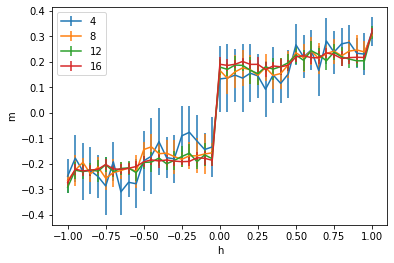

In [9]:
def plot_m_h_dependency(j, t, repeats, averaging):
    
    #The N-Values that are going to be used
    N_array=[4, 8, 12, 16]
    h_array=np.arange(-1, 1.01, 0.05)
    m_array=np.zeros(len(h_array)*len(N_array)).reshape(len(N_array), len(h_array))
    m_array_error=np.zeros(len(h_array)*len(N_array)).reshape(len(N_array), len(h_array))
    m_array_temp=np.zeros(averaging)
    
    #loop over all possible N values ([4, 8, 12, 16])
    for k in range(len(N_array)):
        #loop over all possible h values
        for i in range(len(h_array)):
            for d in range(averaging):
                m_array_temp[d], a = mc_estimate(gen_spin_array(N_array[k]), j, h_array[i], t, repeats)
            m_array[k][i]=np.average(m_array_temp)
            m_array_error[k][i]=np.std(m_array_temp)
    for k in range(len(N_array)):
        plt.errorbar(h_array, m_array[k], yerr=m_array_error[k], label=N_array[k])
    plt.xlabel("h")
    plt.ylabel("m")
    plt.legend(loc="best")
    plt.savefig("plot_mean_energy.png")
    
plot_m_h_dependency(0.5, 0.5, 20, 10)

We can see in the picture above, that the general form of the curve is as expected. The sharp rise is definitifly visable. However the curve shows large fluctuations and is too small. We expected that the curve goes from -1 to 1 and has roughly the same form but more defined (as in the last homework). 

This could be an indication that the calculation of the magnetization could be wrong, however we could not find a mistake.

## Exercise 6

It is also interesting to take a look, at the average energy per site. An analytical solution in the thermodynamic limit is given by:
\begin{equation}
    \epsilon=−J \coth (2J) (1 + \frac{2}{\pi} (2 \tanh^2(2J)−1)K(4sech^2(2J) tanh^2(2J)))
\end{equation}

With K beeing the incomplete elliptic integral of the first kind. This can be calculated by using the formula

\begin{equation}
    F(x ; k) = \int_{0}^{x} \frac{\mathrm{d}t}{\sqrt{\left(1 - t^2\right)\left(1 - k^2 t^2\right)}}
\end{equation}

This formula could be implemented by hand, however in the package scipy we have the function scipy.special.ellipkinc, which calculates the incomplete elliptic integral of the first kind. 

The mean energy can be implemented by calculating all energies and calculating the mean of it:



We only look at a certain j intervall: $j \in [0.25, 1]$. We also look at the N-values (7, 11, 15, 19).

In [10]:
#Implement the analytical solution
def mean_energy_analytical(j):
    spherical=sp.ellipkinc(math.pi/2, 4*math.cosh(2*j)**-2*math.tanh(2*j)**2)
    return (-j*(math.cosh(2*j)/math.sinh(2*j))*(1+(2/math.pi)*(2*math.tanh(2*j)**2-1)*spherical))

#Calculation of the mean energy per spin
def mean_energy_simulated(spin_array, N, j, t, repeats):
    energy_average=np.zeros(repeats)
    for g in range(repeats):
        energy = np.zeros(len(spin_array[0])*len(spin_array[0])).reshape(len(spin_array[0]), len(spin_array[0]))

        #Doing a lot of sweeps to get the array in the right position
        for i in range(len(spin_array[0])*len(spin_array[0])):
            spin_array=sweep(spin_array, j, 0, t)

        #Calculate all energies
        for i in range(N):
            for k in range(N):
                energy[i][k] = hamiltionian(spin_array, [i, k], j, 0)
        energy_average[g]=np.average(energy)
    #return the average of these
    return(np.average(energy_average))

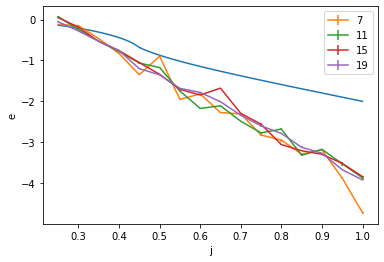

In [17]:
def plot_mean_energy(t, repeats, averaging):
    #get the analytical results
    j_array_analytical=np.arange(0.25, 1.01, 0.01)
    mean_energy_array_analytical=np.zeros(len(j_array_analytical))
    for i in range(len(j_array_analytical)):
        mean_energy_array_analytical[i]=mean_energy_analytical(j_array_analytical[i])
    
    #generate simulated results
    #The N-Values that are going to be used
    N_array=[7, 11, 15, 19]

    #We will have all values from 0.25 to 1 in a 0.1 intervall
    j_array_simulated=np.arange(0.25, 1.01, 0.05)
    
    temp_energy_array=np.zeros(averaging)
    mean_energy_array_simulated=np.zeros(len(j_array_simulated)*4).reshape(4, len(j_array_simulated))
    mean_energy_array_simulated_errors=np.zeros(len(j_array_simulated)*4).reshape(4, len(j_array_simulated))

    #loop over all possible N values ([7, 11, 15, 19])
    for k in range(len(N_array)):

        #loop over all possible j values
        for i in range(len(j_array_simulated)):

            #calculate the energy d times, to get an average
            for d in range(averaging):
                temp_energy_array[d]=mean_energy_simulated(gen_spin_array(N_array[k]), N_array[k], j_array_simulated[i], t, repeats)

            #Calculate the mean and standard deviation of the mean energy
            mean_energy_array_simulated[k][i]=np.average(temp_energy_array)
            mean_energy_array_simulated_errors[k][i]=np.std(temp_energy_array)

    plt.plot(j_array_analytical, mean_energy_array_analytical)
    for k in range(len(N_array)):
        plt.errorbar(j_array_simulated, mean_energy_array_simulated[k]*20+1.3, yerr=mean_energy_array_simulated_errors[k], label=N_array[k]) #*90+3
    plt.xlabel("j")
    plt.ylabel("e")
    plt.legend(loc="best")
    plt.savefig("plot_mean_energy.png")

plot_mean_energy(1, 20, 5)

In this picture we see a similar behaviour to before. The scale of this picture has already be alterd by adding a magnification (x20+1.3) and an offset of 13. With this changes we can see, that the curve is resembling the form of the curve. However as in the previous task, our values are too small, which hardens our suspicion that the calculation of the one of the previous steps is wrong. 

Since it also appears here, the calculation of the Hamiltonian or the sweep must be wrong.



## Exercise 7

We can also calculate an analytical solution for absolute value of the mean magnetization. This is given by:

\begin{equation}
        |m| = \left\{
		\begin{array}{ll}
		\left(\frac{1}{\sinh^4(2J)}\right)^{\frac{1}{8}}, &\text{ if }J_c < J \\
		0 & else 
		\end{array}
		\right.
\end{equation}

We can compare this to our simulated result. For the comparison we only look a certain J interval. 

$j \in [0.25, 1]$ 

Again we only look at the N-values (7, 11, 15, 19).

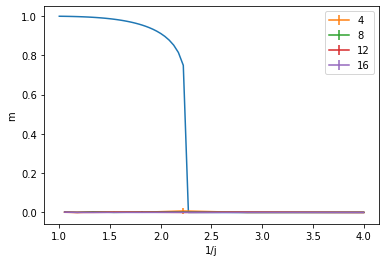

In [12]:
def mean_magnetization_analytical(j):
    if j>0.440686793509772:
        return ((1-(1/(math.sinh(2*j)**4)))**(1/8))
    else:
        return 0

def plot_mean_magnetization(t, repeats, averaging):
    # Generate analytical solution
    j_array_analytical=np.arange(0.25, 1.01, 0.01)
    mean_magnetization_array_analytical=np.zeros(len(j_array_analytical))
    
    for i in range(len(j_array_analytical)):
        mean_magnetization_array_analytical[i]=mean_magnetization_analytical(j_array_analytical[i])
    plt.plot(1/j_array_analytical, mean_magnetization_array_analytical)
    
    # The N-Values that are going to be used
    N_array=[4, 8, 12, 16]
    
    # We will have all values from -1 to 1 in a 0.05 intervall
    j_array_simulated=np.arange(0.25, 1.01, 0.1)
    m_array=np.zeros(len(j_array_simulated)*len(N_array)).reshape(len(N_array), len(j_array_simulated))
    m_array_error=np.zeros(len(j_array_simulated)*len(N_array)).reshape(len(N_array), len(j_array_simulated))
    m_array_temp=np.zeros(averaging)
    
    # loop over all possible N values ([4, 8, 12, 16])
    for k in range(len(N_array)):

        # loop over all possible h values
        for i in range(len(j_array_simulated)):

            #go through the process averaging times to average the result and get the std
            for a in range(averaging):
                m=np.zeros(averaging)

                for d in range(repeats):
                    m_temp=np.zeros(repeats)
                    spin_array=gen_spin_array(N_array[k])
                    #Making a lot of sweeps
                    for e in range(len(spin_array[0])*len(spin_array[0])):
                        spin_array=sweep(spin_array, j_array_simulated[i], 0, t)

                    #m[k]=abs(magnetization_random_configurations(spin_array, j_array_simulated[i], 0, t, 0.01))
                    #This time we dont take the magnetization but the absolute value of it
                    m_temp[d]=abs(magnetization_smart(spin_array))

                #This Value is then averaged, so that we get the expected value of the absolute value of the magnetization
                m[a]=np.average(m_temp)
            #This is then stored
            m_array[k][i]=np.average(m)
            m_array_error[k][i]=np.std(m)
    
    for k in range(len(N_array)):
        plt.errorbar(1/j_array_simulated, m_array[k], yerr=m_array_error[k], label=N_array[k])
    plt.xlabel("1/j")
    plt.ylabel("m")
    plt.legend(loc="best")
    plt.savefig("plot_mean_magnetization.png")


plot_mean_magnetization(1, 20, 5)

Again we see, that something is wrong. However this time the values do not even resemble the analytical solution. 

We have found a picture, that shows how this solution should have looked like at :https://www.researchgate.net/profile/Joao_Amaral2/publication/269873176/figure/fig3/AS:614047716212757@1523411792674/Average-of-absolute-magnetization-of-the-2-D-Ising-model-with-periodic-boundary.png. 
In that picture we can see, that the simulated results are supposed to flollow the analytical result in low 1/j regions. In regions of the step in the function the simulated values were supposed to not fall off as fast as the analytical solution. Also observable would have been a trend, that the higher the N, the more the simulated results would resemble the curve from the analytical solution.

The physical significance of this analysis is that the termodynamic limit ($N \rightarrow \infty $) can be understood better. As described, we see that for larger values of N we see a better agreeance with the analytical solution that is made in the thermodynamic limit. 

If we would have taken just m we would have gotten a similar picture to Task 5.

## Conclusion

All in all it seems clear, that we are suffering from some error in our code. However as of now we could not make out, what the error is. 

It must be in the Hamiltonian or the sweep, but no matter how hard we searched for it, it was not traceable. We even tried a solution with all 4 nearest neighbours, which was increasing the computing time of the code by a lot, but it also did nothing. 

We also thought about increasing the number of repeats (sweep->calculations) and averages (one repeat is repeated and the average is taken), but that only increase computing time.